In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import os

In [13]:
dataset_dir = 'D:\\Eye\\Eye Research\\Dataset Collected\\CCN'

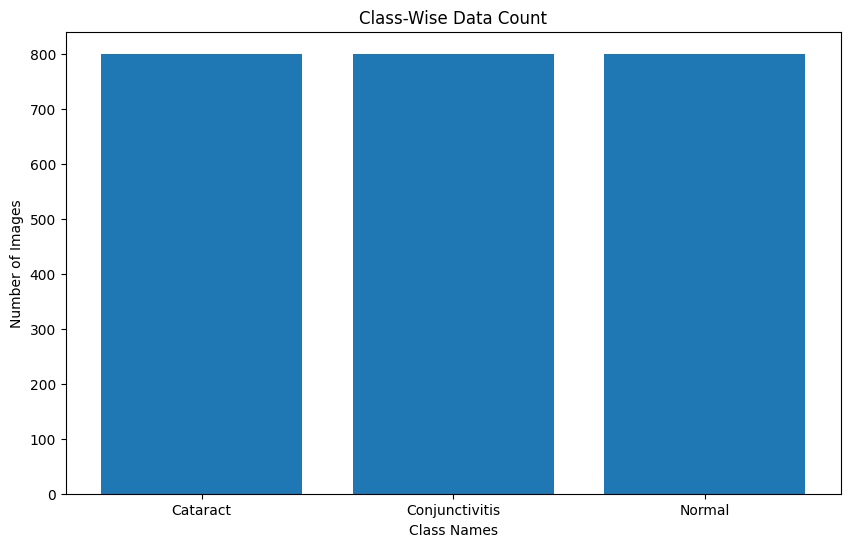

In [14]:
class_counts = {}
for subdir, dirs, files in os.walk(dataset_dir):
    for dir in dirs:
        class_counts[dir] = len(os.listdir(os.path.join(subdir, dir)))

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class-Wise Data Count')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.show()

In [15]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

test_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 2160 images belonging to 3 classes.
Found 240 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.


In [16]:
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 2400 images belonging to 3 classes.


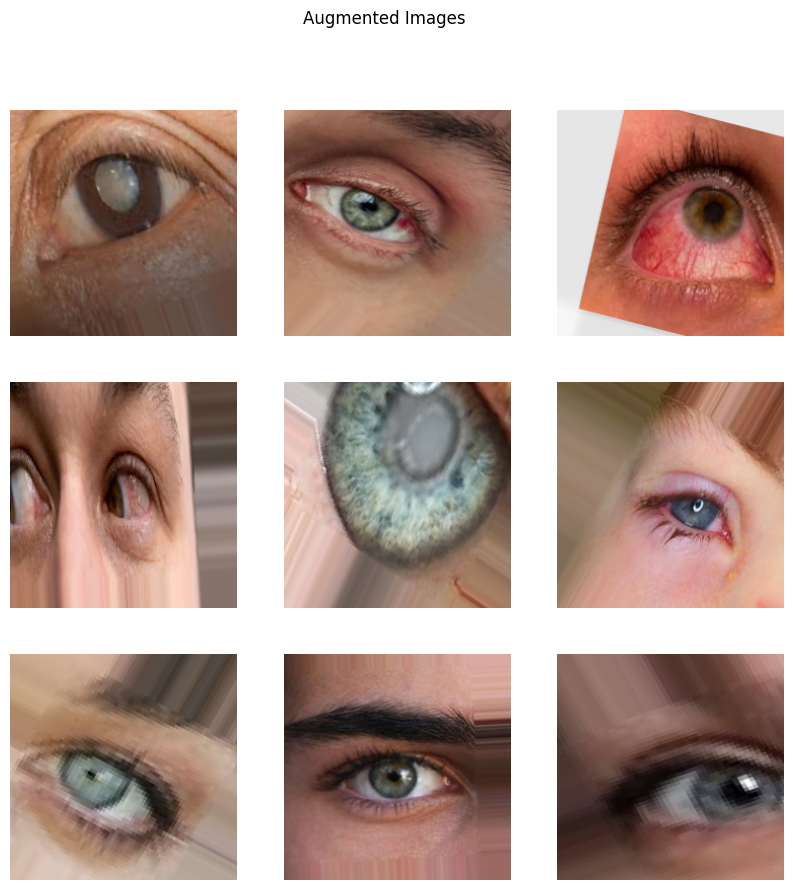

In [17]:
def plot_images(generator, title):
    sample_images, _ = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(sample_images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()
plot_images(augmented_datagen.flow_from_directory(dataset_dir, target_size=(224, 224), batch_size=32, class_mode='sparse', subset='training'), "Augmented Images")

In [18]:
def create_vgg19_model(input_shape=(224, 224, 3), num_classes=3):
    vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in vgg19_base.layers:
        layer.trainable = False

    x = Flatten()(vgg19_base.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=vgg19_base.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [19]:
def generator_to_numpy(generator):
    images = []
    labels = []
    for _ in range(len(generator)):
        img, lbl = next(generator)
        images.append(img)
        labels.append(lbl)
    return np.concatenate(images), np.concatenate(labels)

X, y = generator_to_numpy(train_generator)

In [20]:
def calculate_metrics(conf_matrix):
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    TN = conf_matrix.sum() - (FP + FN + TP)

    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)

    return TPR, TNR, FPR, FNR

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
accuracies = []
histories = []

In [22]:

for train_index, val_index in kf.split(X):
    print(f"Training fold {fold_no}...")
    
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_vgg19_model()

    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))
    histories.append(history)

    y_val_pred = model.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    
    print(f"Fold {fold_no} - Validation Accuracy: {history.history['val_accuracy'][-1]}")

Training fold 1...


Epoch 1/20


54/54 [==============================] - 358s 7s/step - loss: 0.6871 - accuracy: 0.7072 - val_loss: 0.3005 - val_accuracy: 0.8981
Epoch 2/20
54/54 [==============================] - 385s 7s/step - loss: 0.2921 - accuracy: 0.8912 - val_loss: 0.2372 - val_accuracy: 0.9259
Epoch 3/20
54/54 [==============================] - 380s 7s/step - loss: 0.2125 - accuracy: 0.9242 - val_loss: 0.2302 - val_accuracy: 0.9190
Epoch 4/20
54/54 [==============================] - 376s 7s/step - loss: 0.1701 - accuracy: 0.9439 - val_loss: 0.1899 - val_accuracy: 0.9259
Epoch 5/20
54/54 [==============================] - 379s 7s/step - loss: 0.1340 - accuracy: 0.9572 - val_loss: 0.1634 - val_accuracy: 0.9468
Epoch 6/20
54/54 [==============================] - 381s 7s/step - loss: 0.1003 - accuracy: 0.9705 - val_loss: 0.1512 - val_accuracy: 0.9491
Epoch 7/20
54/54 [==============================] - 380s 7s/step - loss: 0.0927 - accuracy: 0.9722 - val_loss: 0.1433 - val_accurac

In [28]:
conf_matrices = []
classification_reports = []
tpr_list = []
tnr_list = []
fpr_list = []
fnr_list = []

In [29]:
for fold_no, history in enumerate(histories, 1):
    val_predictions = np.argmax(history.model.predict(X_val), axis=1)

    conf_matrix = confusion_matrix(y_val, val_predictions)
    conf_matrices.append(conf_matrix)
    
    class_report = classification_report(y_val, val_predictions, target_names=list(class_counts.keys()))
    classification_reports.append(class_report)
    
    TPR, TNR, FPR, FNR = calculate_metrics(conf_matrix)
    tpr_list.append(TPR)
    tnr_list.append(TNR)
    fpr_list.append(FPR)
    fnr_list.append(FNR)
    
    print(f"Fold {fold_no} - Classification Report:\n{class_report}")
    print(f"Fold {fold_no} - Confusion Matrix:\n{conf_matrix}")
    print(f"Fold {fold_no} - TPR: {TPR}")
    print(f"Fold {fold_no} - TNR: {TNR}")
    print(f"Fold {fold_no} - FPR: {FPR}")
    print(f"Fold {fold_no} - FNR: {FNR}")

14/14 [==============================] - 81s 6s/step
Fold 1 - Classification Report:
                precision    recall  f1-score   support

      Cataract       1.00      1.00      1.00       162
Conjunctivitis       1.00      1.00      1.00       130
        Normal       1.00      1.00      1.00       140

      accuracy                           1.00       432
     macro avg       1.00      1.00      1.00       432
  weighted avg       1.00      1.00      1.00       432

Fold 1 - Confusion Matrix:
[[162   0   0]
 [  0 130   0]
 [  0   0 140]]
Fold 1 - TPR: [1. 1. 1.]
Fold 1 - TNR: [1. 1. 1.]
Fold 1 - FPR: [0. 0. 0.]
Fold 1 - FNR: [0. 0. 0.]
14/14 [==============================] - 68s 5s/step
Fold 2 - Classification Report:
                precision    recall  f1-score   support

      Cataract       1.00      1.00      1.00       162
Conjunctivitis       1.00      1.00      1.00       130
        Normal       1.00      1.00      1.00       140

      accuracy                      

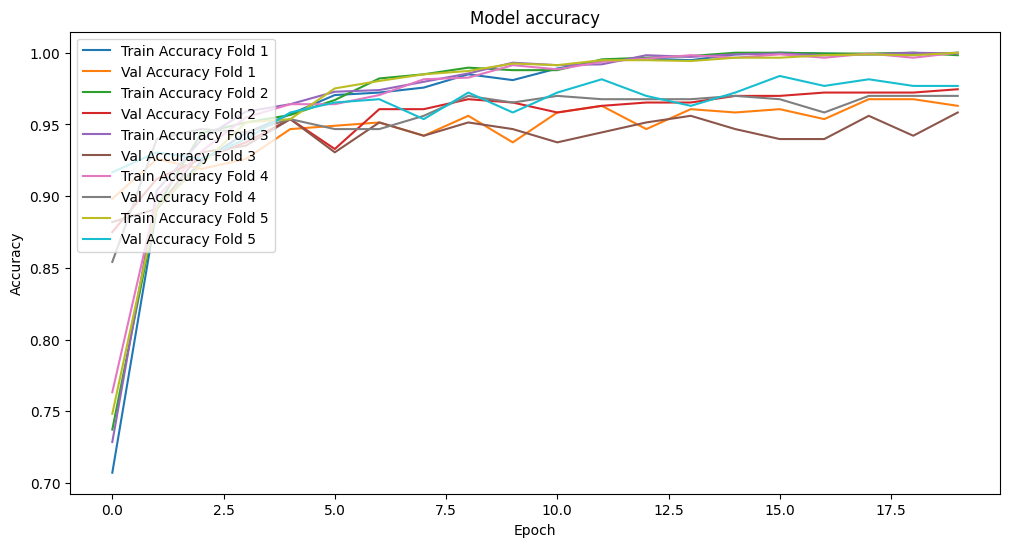

In [31]:
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Train Accuracy Fold {i+1}')
    plt.plot(history.history['val_accuracy'], label=f'Val Accuracy Fold {i+1}')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Average Validation Accuracy: 0.9685185194015503
Validation Accuracies for each fold: [0.9629629850387573, 0.9745370149612427, 0.9583333134651184, 0.9699074029922485, 0.9768518805503845]
76/76 [==============================] - 652s 9s/step
Test Classification Report:
                precision    recall  f1-score   support

      Cataract       0.99      1.00      0.99       800
Conjunctivitis       1.00      0.99      0.99       800
        Normal       0.99      0.99      0.99       800

      accuracy                           0.99      2400
     macro avg       0.99      0.99      0.99      2400
  weighted avg       0.99      0.99      0.99      2400

Test Confusion Matrix:
[[797   1   2]
 [  5 792   3]
 [  4   2 794]]
Test TPR: [0.99625 0.99    0.9925 ]
Test TNR: [0.994375 0.998125 0.996875]
Test FPR: [0.005625 0.001875 0.003125]
Test FNR: [0.00375 0.01    0.0075 ]


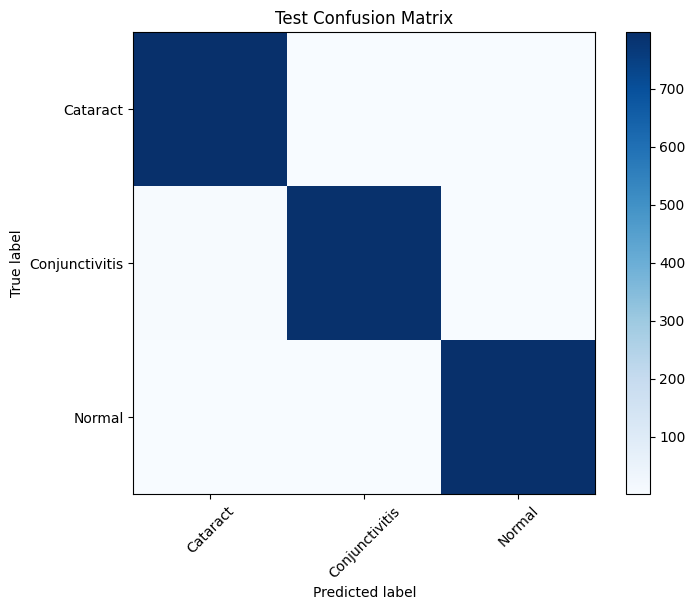

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

accuracies = [history.history['val_accuracy'][-1] for history in histories]

if accuracies:
    average_val_accuracy = np.mean(accuracies)
    print(f"Average Validation Accuracy: {average_val_accuracy}")
    print(f"Validation Accuracies for each fold: {accuracies}")

    best_fold = np.argmax(accuracies)
    best_model = histories[best_fold].model

    test_generator.reset()
    y_test = test_generator.classes
    y_test_pred = best_model.predict(test_generator, steps=test_generator.n // test_generator.batch_size + 1)
    y_test_pred_classes = np.argmax(y_test_pred, axis=1)

    conf_matrix_test = confusion_matrix(y_test, y_test_pred_classes)
    class_report_test = classification_report(y_test, y_test_pred_classes, target_names=list(class_counts.keys()))

    print(f"Test Classification Report:\n{class_report_test}")
    print(f"Test Confusion Matrix:\n{conf_matrix_test}")

    TPR_test, TNR_test, FPR_test, FNR_test = calculate_metrics(conf_matrix_test)
    print(f"Test TPR: {TPR_test}")
    print(f"Test TNR: {TNR_test}")
    print(f"Test FPR: {FPR_test}")
    print(f"Test FNR: {FNR_test}")
else:
    print("No validation accuracies recorded. Please check the training loop.")

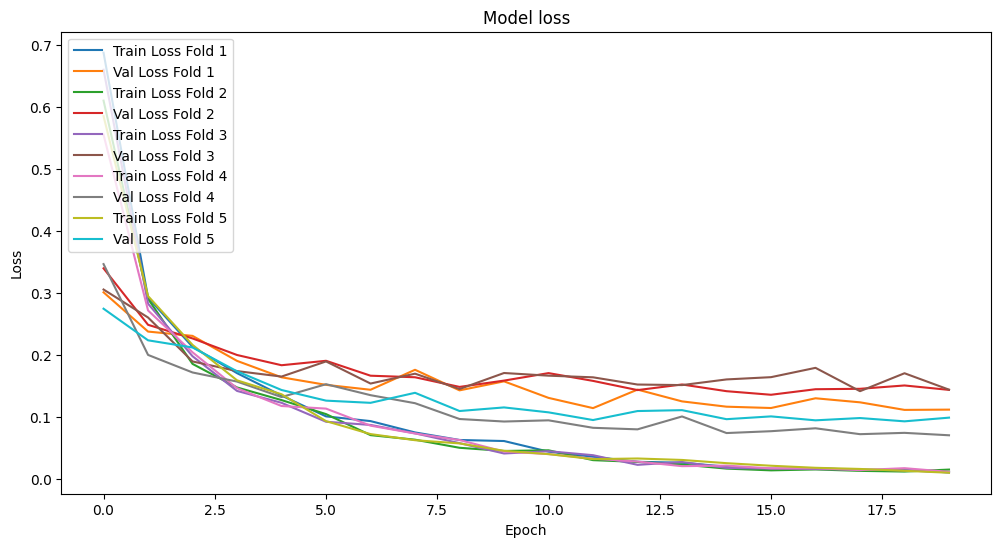

In [32]:
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Train Loss Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Val Loss Fold {i+1}')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [34]:
avg_tpr = np.mean(tpr_list, axis=0)
avg_tnr = np.mean(tnr_list, axis=0)
avg_fpr = np.mean(fpr_list, axis=0)
avg_fnr = np.mean(fnr_list, axis=0)

print(f"Average TPR: {avg_tpr}")
print(f"Average TNR: {avg_tnr}")
print(f"Average FPR: {avg_fpr}")
print(f"Average FNR: {avg_fnr}")

Average TPR: [0.99753086 0.99230769 0.99571429]
Average TNR: [0.9962963  0.9986755  0.99794521]
Average FPR: [0.0037037  0.0013245  0.00205479]
Average FNR: [0.00246914 0.00769231 0.00428571]


Test Confusion Matrix:
[[797   1   2]
 [  5 792   3]
 [  4   2 794]]


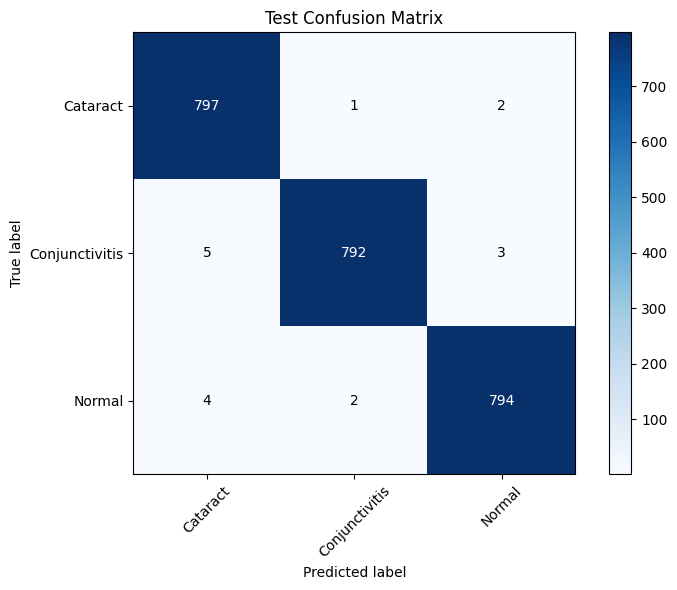

In [40]:
print(f"Test Confusion Matrix:\n{conf_matrix_test}")

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_test, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Test Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_counts))
plt.xticks(tick_marks, class_counts.keys(), rotation=45)
plt.yticks(tick_marks, class_counts.keys())

plt.ylabel('True label')
plt.xlabel('Predicted label')

thresh = conf_matrix_test.max() / 2.
for i, j in np.ndindex(conf_matrix_test.shape):
    plt.text(j, i, format(conf_matrix_test[i, j], 'd'),
             ha="center", va="center",
             color="white" if conf_matrix_test[i, j] > thresh else "black")

plt.tight_layout()
plt.show()